# 学習率を指数減衰させて学習

In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
%env TOKEN=*************************************
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

env: TOKEN=*************************************
Cloning into 'MOD2NN'...
remote: Enumerating objects: 1424, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1424 (delta 100), reused 133 (delta 64), pack-reused 1235
Receiving objects: 100% (1424/1424), 41.09 MiB | 39.92 MiB/s, done.
Resolving deltas: 100% (805/805), done.
Mounted at /content/drive


In [2]:
import time
import os
import json
import sys
import re
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.2
Python: 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]


In [16]:
class MO(tf.keras.layers.Layer):
    def __init__(self, output_dim, limitation=None, theta=0.0, eta=0.0, kernel_regularizer=None, kernel_initializer=None, trainable=True, name=None, dtype=tf.float32, dynamic=False, **kwargs):
        super(MO, self).__init__(
            trainable=trainable,
            name=name,
            dtype=dtype,
            dynamic=dynamic,
            **kwargs
        )
        self.output_dim = output_dim

        self.limitation = limitation if limitation is not None else "None"
        self.theta = tf.cast(theta, self.dtype)
        self.eta = tf.cast(eta, self.dtype)
        self.eta_max = tf.cast(abs(eta), self.dtype)
        self.alpha = tf.cast(tf.math.log((1. + self.eta) / (1. - self.eta)) / 2., self.dtype)
        self.phi_common = tf.complex(tf.constant(0., dtype=tf.float32), tf.constant(1. + self.eta_max, dtype=tf.float32))
        self.kernel_regularizer = kernel_regularizer
        self.kernel_initializer = kernel_initializer
        assert len(self.output_dim) == 2
        assert -1.0 < self.eta < 1.0

    def build(self, input_dim):
        self.input_dim = input_dim
        self.mag = self.add_weight("magnetization",
                                   shape=[int(input_dim[-2]),
                                          int(input_dim[-1])],
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   dtype=self.dtype)
        super(MO, self).build(input_dim)

    @tf.function
    def get_limited_theta(self):
        if self.limitation == 'tanh':
            return tf.complex(self.theta * tf.tanh(self.mag), tf.zeros_like(self.mag))
        elif self.limitation == 'sin':
            return tf.complex(self.theta * tf.sin(self.mag), tf.zeros_like(self.mag))
        elif self.limitation == 'sigmoid':
            return tf.complex(self.theta * (2.0 * tf.sigmoid(self.mag) - 1.0), tf.zeros_like(self.mag))
        else:
            return tf.complex(self.theta * self.mag, tf.zeros_like(self.mag))

    @tf.function
    def get_limited_eta(self):
        if self.limitation == 'tanh':
            return self.eta * tf.tanh(self.mag)
        elif self.limitation == 'sin':
            return self.eta * tf.sin(self.mag)
        elif self.limitation == 'sigmoid':
            return self.eta * (2.0 * tf.sigmoid(self.mag) - 1.0)
        else:
            return self.eta * self.mag

    @tf.function
    def get_limited_complex_faraday(self):
        theta = self.theta * tf.sin(self.mag)
        alpha = self.alpha * tf.sin(self.mag)
        return tf.complex(theta, alpha)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "limitation": self.limitation,
            "theta": float(self.theta.numpy()),
            "eta": float(self.eta.numpy())
        })
        if self.kernel_regularizer:
            config.update({
                "reguralizer": self.kernel_regularizer.get_config()
            })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, x):
        phi = self.get_limited_complex_faraday()

        rcp_x = tf.keras.layers.Lambda(lambda x: x[:, 0, :, :])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x: x[:, 1, :, :])(x)

        rcp_x_mo = rcp_x * tf.exp(-1.j * phi) * tf.exp(1.j * self.phi_common)
        lcp_x_mo = lcp_x * tf.exp(1.j * phi) * tf.exp(1.j * self.phi_common)

        return tf.stack([rcp_x_mo, lcp_x_mo], axis=1)

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
#@title デフォルトのタイトル テキスト
wavelength = 633.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}
z = 0.7e-3 #@param {type:"number"}

In [50]:
def create_model(**kwargs):
    shape = (100, 100)
    theta = kwargs["theta"]
    eta = 0.
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = Polarizer(shape, trainable=True)(x)
    x = ElectricFieldToIntensity(shape)(x)
    x = MNISTDetector(shape)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [23]:
model = create_model(seed=1, theta=1.)
model.save("test")
with open("config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [18]:
def train(seed, theta, num):
    model_name = "20221013_" + str(num)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = cholab_path + "trained_model/"+ model_name

    model = create_model(seed=seed, theta=theta)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=["accuracy"]
                  )

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.0001
      n = 50
      a = -1/(n-1) * np.log(end/start)
      return np.exp(-a*(epoch)) * start
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[lr_callback, cp_callback, tensorboard_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [19]:
theta_list =[np.pi, np.pi/5, np.pi/10, np.pi/100]
for i, theta in enumerate(theta_list):
    train(seed=1, theta=theta, num=i+1)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_7 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _7 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 angular_spectrum_36 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_30 (MO)                  (None, 2, 100, 100)       1000

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_8 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _8 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 angular_spectrum_42 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_35 (MO)                  (None, 2, 100, 100)       1000

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_9 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _9 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 angular_spectrum_48 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_40 (MO)                  (None, 2, 100, 100)       1000

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_10 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _10 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_54 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_45 (MO)                  (None, 2, 100, 100)       1000

In [13]:
def create_model(**kwargs):
    shape = (100, 100)
    theta = kwargs["theta"]
    eta = 0.
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = FaradayRotationByStokes(shape)(x)
    x = MNISTDetector(shape)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [14]:
def train(seed, theta, num):
    model_name = "20221013_" + str(num)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = cholab_path + "trained_model/"+ model_name

    model = create_model(seed=seed, theta=theta)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=["accuracy"]
                  )

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.0001
      n = 50
      a = -1/(n-1) * np.log(end/start)
      return np.exp(-a*(epoch)) * start
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[lr_callback, cp_callback, tensorboard_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [15]:
theta_list =[np.pi/50, np.pi/100, np.pi/200, np.pi/1000]
for i, theta in enumerate(theta_list):
    train(seed=1, theta=theta, num=i+5)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_3 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _3 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 angular_spectrum_12 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_10 (MO)                  (None, 2, 100, 100)       1000

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_4 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _4 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 angular_spectrum_18 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_15 (MO)                  (None, 2, 100, 100)       1000

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_5 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _5 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 angular_spectrum_24 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_20 (MO)                  (None, 2, 100, 100)       1000

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_6 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _6 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 angular_spectrum_30 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_25 (MO)                  (None, 2, 100, 100)       1000

In [27]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18  # 適当に必要なサイズに

# figure
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2
plt.rcParams["savefig.transparent"] = True

# ticks
plt.rcParams['xtick.direction'] = 'in'  # in or out
plt.rcParams['ytick.direction'] = 'in'

# axes
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.linewidth"] = 2.0
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = "black"

# legend
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更

# image
plt.rcParams["image.interpolation"] = "none"
plt.rcParams["image.aspect"] = "equal"

In [35]:
path = "/content/drive/MyDrive/D2NN/trained_model/20221013_*"
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))

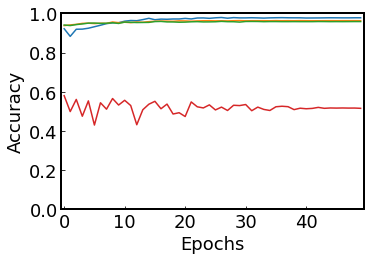

In [49]:
for i in range(4):
  result = pd.read_csv(files[i]+"/history.csv")
  plt.plot(result["val_accuracy"])

plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("analyzer.png")

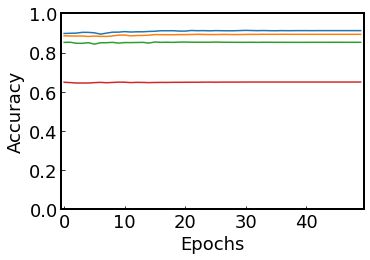

In [47]:
for i in range(4,8):
  result = pd.read_csv(files[i]+"/history.csv")
  plt.plot(result["val_accuracy"])

plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("faraday.png")

In [43]:
tet_acc = []

for _file in files:
  model = tf.keras.models.load_model(_file)
  eval = model.evaluate(x_test, y_test)
  tet_acc.append(eval[1])

plt.savefig("faraday.png")

 60/313 [====>.........................] - ETA: 2s - loss: 0.1005 - accuracy: 0.9698

KeyboardInterrupt: ignored

# lr = 0.001

In [56]:
def create_model(**kwargs):
    shape = (100, 100)
    theta = kwargs["theta"]
    eta = 0.
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = Polarizer(shape, trainable=True)(x)
    x = ElectricFieldToIntensity(shape)(x)
    x = MNISTDetector(shape)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [52]:
def create_model(**kwargs):
    shape = (100, 100)
    theta = kwargs["theta"]
    eta = 0.
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = FaradayRotationByStokes(shape)(x)
    x = MNISTDetector(shape)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [57]:
def train(seed, theta, num):
    model_name = "20221014_" + str(num)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = cholab_path + "trained_model/"+ model_name

    model = create_model(seed=seed, theta=theta)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=["accuracy"]
                  )

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [59]:
theta_list =[np.pi, np.pi/5, np.pi/10, np.pi/100]
for i, theta in enumerate(theta_list):
    train(seed=1, theta=theta, num=i+1)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_16 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _16 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_90 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_75 (MO)                  (None, 2, 100, 100)       100

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_17 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _17 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_96 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_80 (MO)                  (None, 2, 100, 100)       100

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_18 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _18 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_102 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_85 (MO)                  (None, 2, 100, 100)       100

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_19 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _19 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_108 (Angul  (None, 2, 100, 100)      0         
 arSpectrum)                                                     
                                                                 
 mo_90 (MO)                  (None, 2, 100, 100)       100

In [58]:
theta_list =[np.pi/50, np.pi/100, np.pi/200, np.pi/1000]
for i, theta in enumerate(theta_list):
    train(seed=1, theta=theta, num=i+5)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_15 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _15 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 angular_spectrum_84 (Angula  (None, 2, 100, 100)      0         
 rSpectrum)                                                      
                                                                 
 mo_70 (MO)                  (None, 2, 100, 100)       100

KeyboardInterrupt: ignored

In [60]:
path = "/content/drive/MyDrive/D2NN/trained_model/20221014_*"
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))

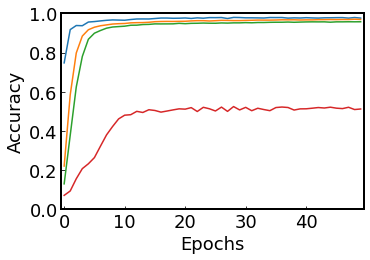

In [62]:
for i in range(4):
  result = pd.read_csv(files[i]+"/history.csv")
  plt.plot(result["val_accuracy"])

plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("analyzer_lr_const.png")

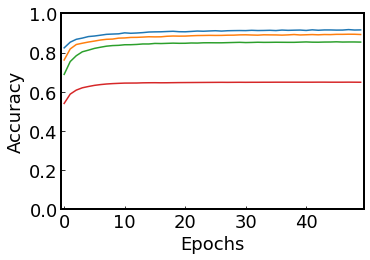

In [63]:
for i in range(4,8):
  result = pd.read_csv(files[i]+"/history.csv")
  plt.plot(result["val_accuracy"])

plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("faraday_lr_const.png")